In [226]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600

In [256]:
# -----------------------------------------------
# EQUATIONS FOR THE MODEL ITSELF
class Plastron():
    # CONSTRUCTOR
    def __init__(self, size, roadtemp, starttemp):
        # Pattern to be applied when running the update() method. One line per vertical section of the plastron
        self.pattern = [[1, 1, 1, 1, 1, 1], 
                        [1, 1, 1, 0, 0, 0], 
                        [0, 0, 0, 0, 0, 0]]
        self.size = size
        self.roadtemp = roadtemp
        self.starttemp = starttemp
        self.currenttemp = starttemp
        # Counter to check what part of the pattern to be used next
        self.counter = 0
        # Lists to hold temperature history and the most recent change
        self.templist0 = []
        self.templist1 = []
        self.templist2 = []
        self.topchange = []
        self.midchange = []
        self.botchange = []
        
    # HELPER METHODS
    def conductionheat(self, size, roadtemp, starting):
        roadtemp += 273 # Kelvin
        t = 1 # seconds
        k = 0.1934 # W/mK
        T1 = starting + 273 # Kelvin
        if size.lower() == "small": 
            d = 0.004 # m
            A = (6542 * (10**-6)) * 0.642 # m^2
        elif size.lower() == "medium":
            d = 0.0050 # m
            A = (9346 * (10**-6)) * 0.590 # m^2
        return k*A*t*((roadtemp-T1)/d) # Return J transferred in that second

    def radiationheat(self, size, roadtemp, starting):
        return self.conductionheat(size, roadtemp - 8.63, starting) # Returns J transferred by radiation
    
    # q = mcat, q in Joules
    def tempraised(self, q, size):
        if size.lower() == "small":
            m = 22.5 # g
        elif size.lower() == "medium":
            m = 36.944 # g
        c = 1.53 # j/g/C
        return q / (m*c) # Returns temperature raised (degrees)
    
    # Returns J raised from a pattern number and a single temp
    def combine(self, condorrad, temp):
        if condorrad == 1:
            return self.tempraised(self.radiationheat(self.size, self.roadtemp, temp), self.size)
        else:
            return self.tempraised(self.conductionheat(self.size, self.roadtemp, temp), self.size)
    
    # MODELING METHODS
    # Updates the Plastron object by 1 second
    def update(self):
        # Creates variable for each vertical section based on the output of combine()
        toptemp = self.combine(self.pattern[0][self.counter], temps[0])
        midtemp = self.combine(self.pattern[1][self.counter], temps[1])
        bottemp = self.combine(self.pattern[2][self.counter], temps[2])
        # Adds temperature changes to each part of currenttemp
        self.currenttemp[0] += toptemp
        self.currenttemp[1] += midtemp
        self.currenttemp[2] += bottemp
        # Most recent change (For deltaheatmap())
        self.topchange = toptemp
        self.midchange = midtemp
        self.botchange = bottemp
        # Checks if counter should be reset
        if self.counter == 5:
            self.counter = 0
        else:
            self.counter += 1
        # Adds current temperature to temperature history
        self.templist0.append(self.currenttemp[0])
        self.templist1.append(self.currenttemp[1])
        self.templist2.append(self.currenttemp[2])

    # Creates a heatmap representation of the current data
    def heatmap(self):
        self.heatmapframe = [[self.currenttemp[0], self.currenttemp[0]],
                             [self.currenttemp[1], self.currenttemp[1]],
                             [self.currenttemp[2], self.currenttemp[2]]]
        return sns.heatmap(self.heatmapframe, cmap='YlOrRd', vmin = 30, vmax = self.roadtemp, linewidths=2, linecolor='black',
                          annot=True, annot_kws={"size": 14},
                          cbar_kws={'label': 'Internal Temperature (°C)'})
    
    # Creates a lineplot of the temperature history for all 3 sections
    def scatter(self):
        return plt.plot(np.arange(0, len(self.templist0)), self.templist0, 'red',
                       np.arange(0, len(self.templist1)), self.templist1, 'orange',
                       np.arange(0, len(self.templist2)), self.templist2, 'yellow')
    
    # (Unused) Creates a heatmap of the most recent change in each section
    def deltaheatmap(self):
        self.heatmapframe = [[self.topchange, self.topchange],
                             [self.midchange, self.midchange],
                             [self.botchange, self.botchange]]
        return sns.heatmap(self.heatmapframe, cmap='YlOrRd', linewidths=2, linecolor='black',
                          annot=True, annot_kws={"size": 14}, fmt='.4g')
# -----------------------------------------------

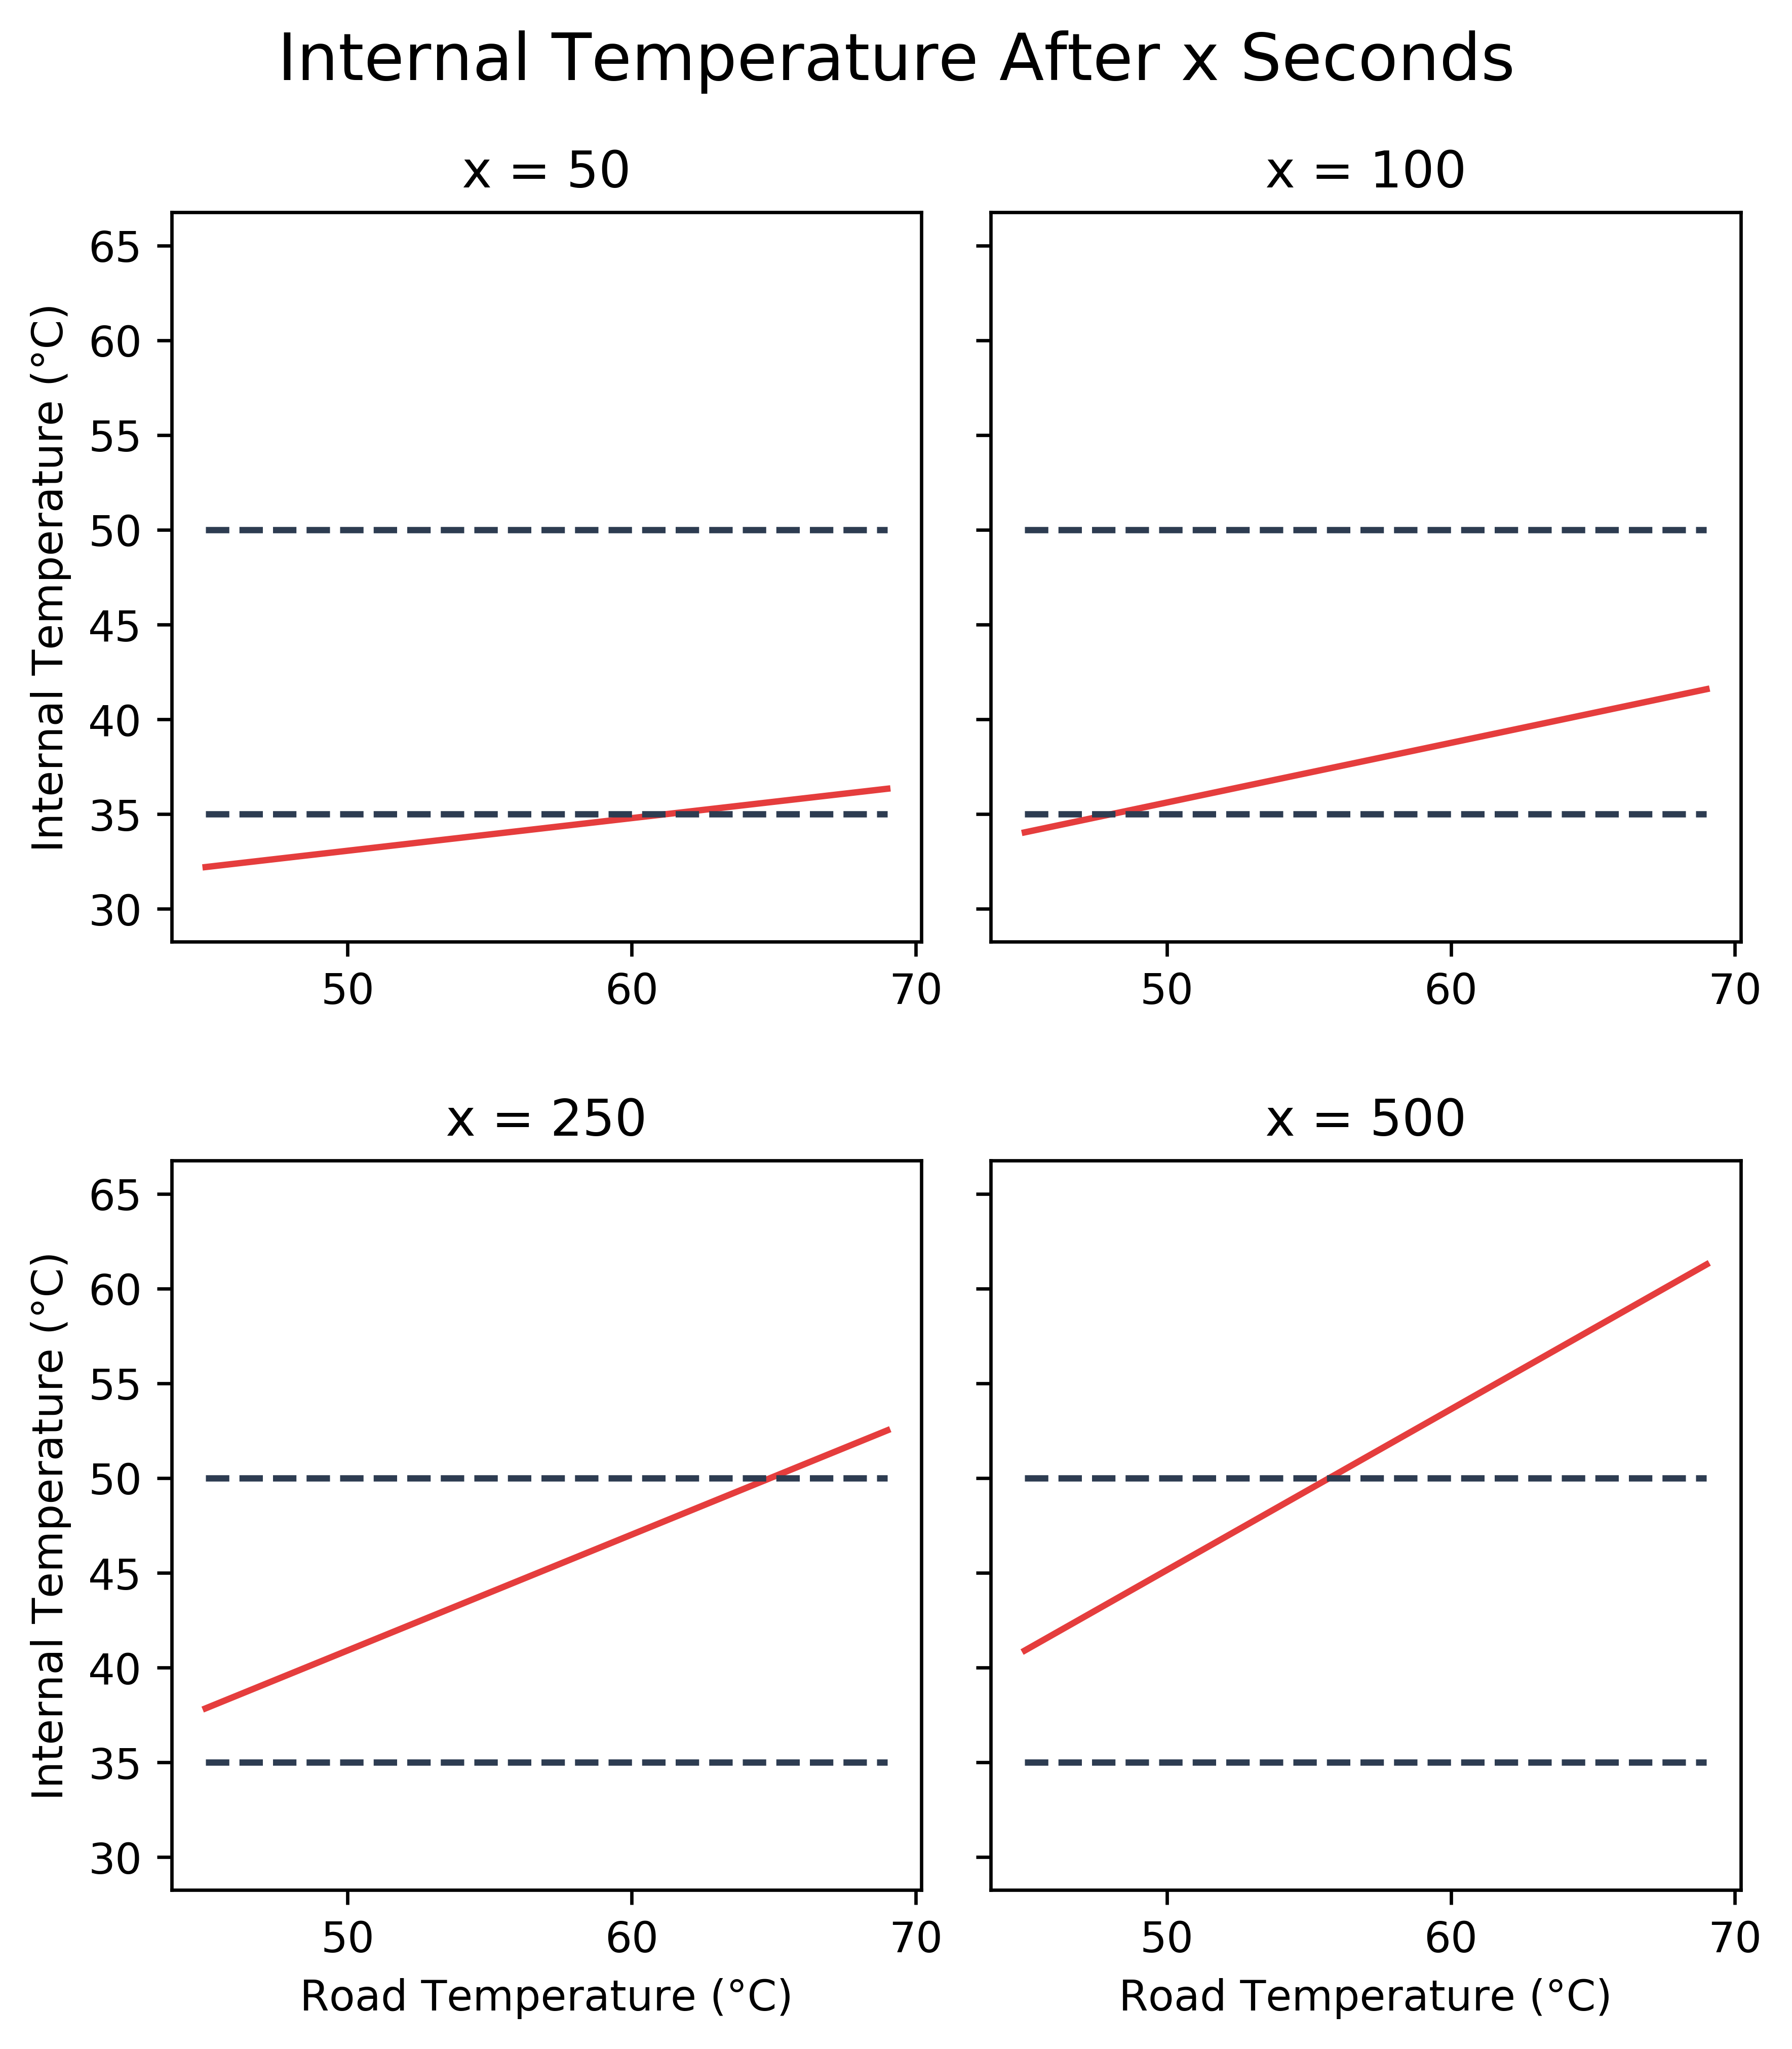

In [228]:

# THE TEMPERATURE AFTER X SECONDS GRAPH
# Create subplot
fig, axes = plt.subplots(2, 2, sharex = False, sharey = True, squeeze = True)

# Subplot for 50 seconds
x = 50
endingtemps = []
for rtemp in range(45, 70):
    temps = [30, 30, 30]
    p = Plastron("medium", rtemp, temps)
    # Updates plastron for x seconds
    for y in range(0, x):
        p.update()
    endingtemps.append((p.currenttemp[1] + p.currenttemp[2]) / 2)
axes[0, 0].plot(np.arange(45, 70), endingtemps, label = "Ending Temperatures", color = '#E53D3D')
axes[0, 0].set_title("x = %s" % x)
axes[0, 0].plot(np.arange(45, 70), np.zeros(25) + 50, label = "50C", color = '#2D3C51', linestyle='dashed')
axes[0, 0].plot(np.arange(45, 70), np.zeros(25) + 35, label = "35C", color = '#2D3C51', linestyle='dashed')
axes[0, 0].plot(np.arange(45, 70), np.zeros(25) + 30, color = '#FFFFFF')
axes[0, 0].plot(np.arange(45, 70), np.zeros(25) + 65, color = '#FFFFFF')
axes[0, 0].set_ylabel("Internal Temperature (°C)")

# Subplot for 100 seconds
x = 100
endingtemps = []
for rtemp in range(45, 70):
    temps = [30, 30, 30]
    p = Plastron("medium", rtemp, temps)
    for y in range(0, x):
        p.update()
    endingtemps.append((p.currenttemp[1] + p.currenttemp[2]) / 2)
axes[0, 1].plot(np.arange(45, 70), endingtemps, label = "Ending Temperatures", color = '#E53D3D')
axes[0, 1].set_title("x = %s" % x)
axes[0, 1].plot(np.arange(45, 70), np.zeros(25) + 50, label = "50C", color = '#2D3C51', linestyle='dashed')
axes[0, 1].plot(np.arange(45, 70), np.zeros(25) + 35, label = "35C", color = '#2D3C51', linestyle='dashed')
axes[0, 1].plot(np.arange(45, 70), np.zeros(25) + 30, color = '#FFFFFF')
axes[0, 1].plot(np.arange(45, 70), np.zeros(25) + 65, color = '#FFFFFF')

# Subplot for 250 seconds
x = 250
endingtemps = []
for rtemp in range(45, 70):
    temps = [30, 30, 30]
    p = Plastron("medium", rtemp, temps)
    for y in range(0, x):
        p.update()
    endingtemps.append((p.currenttemp[1] + p.currenttemp[2]) / 2)
axes[1, 0].plot(np.arange(45, 70), endingtemps, label = "Ending Temperatures", color = '#E53D3D')
axes[1, 0].set_title("x = %s" % x)
axes[1, 0].plot(np.arange(45, 70), np.zeros(25) + 50, label = "50C", color = '#2D3C51', linestyle='dashed')
axes[1, 0].plot(np.arange(45, 70), np.zeros(25) + 35, label = "35C", color = '#2D3C51', linestyle='dashed')
axes[1, 0].plot(np.arange(45, 70), np.zeros(25) + 30, color = '#FFFFFF')
axes[1, 0].plot(np.arange(45, 70), np.zeros(25) + 65, color = '#FFFFFF')
axes[1, 0].set_ylabel("Internal Temperature (°C)")
axes[1, 0].set_xlabel("Road Temperature (°C)")

# Subplot for 500 seconds
x = 500
endingtemps = []
for rtemp in range(45, 70):
    temps = [30, 30, 30]
    p = Plastron("medium", rtemp, temps)
    for y in range(0, x):
        p.update()
    endingtemps.append((p.currenttemp[1] + p.currenttemp[2]) / 2)
axes[1, 1].plot(np.arange(45, 70), endingtemps, label = "Ending Temperatures", color = '#E53D3D')
axes[1, 1].set_title("x = %s" % x)
axes[1, 1].plot(np.arange(45, 70), np.zeros(25) + 50, label = "50C", color = '#2D3C51', linestyle='dashed')
axes[1, 1].plot(np.arange(45, 70), np.zeros(25) + 35, label = "35C", color = '#2D3C51', linestyle='dashed')
axes[1, 1].plot(np.arange(45, 70), np.zeros(25) + 30, color = '#FFFFFF')
axes[1, 1].plot(np.arange(45, 70), np.zeros(25) + 65, color = '#FFFFFF')
axes[1, 1].set_xlabel("Road Temperature (°C)")

fig.suptitle("Internal Temperature After x Seconds", fontsize = 15.5)

plt.tight_layout()
plt.subplots_adjust(top=0.83, bottom=-0.55, hspace = 0.3)

plt.savefig("./graphs/tempafterx.png", dpi=600)
# -----------------------------------------------

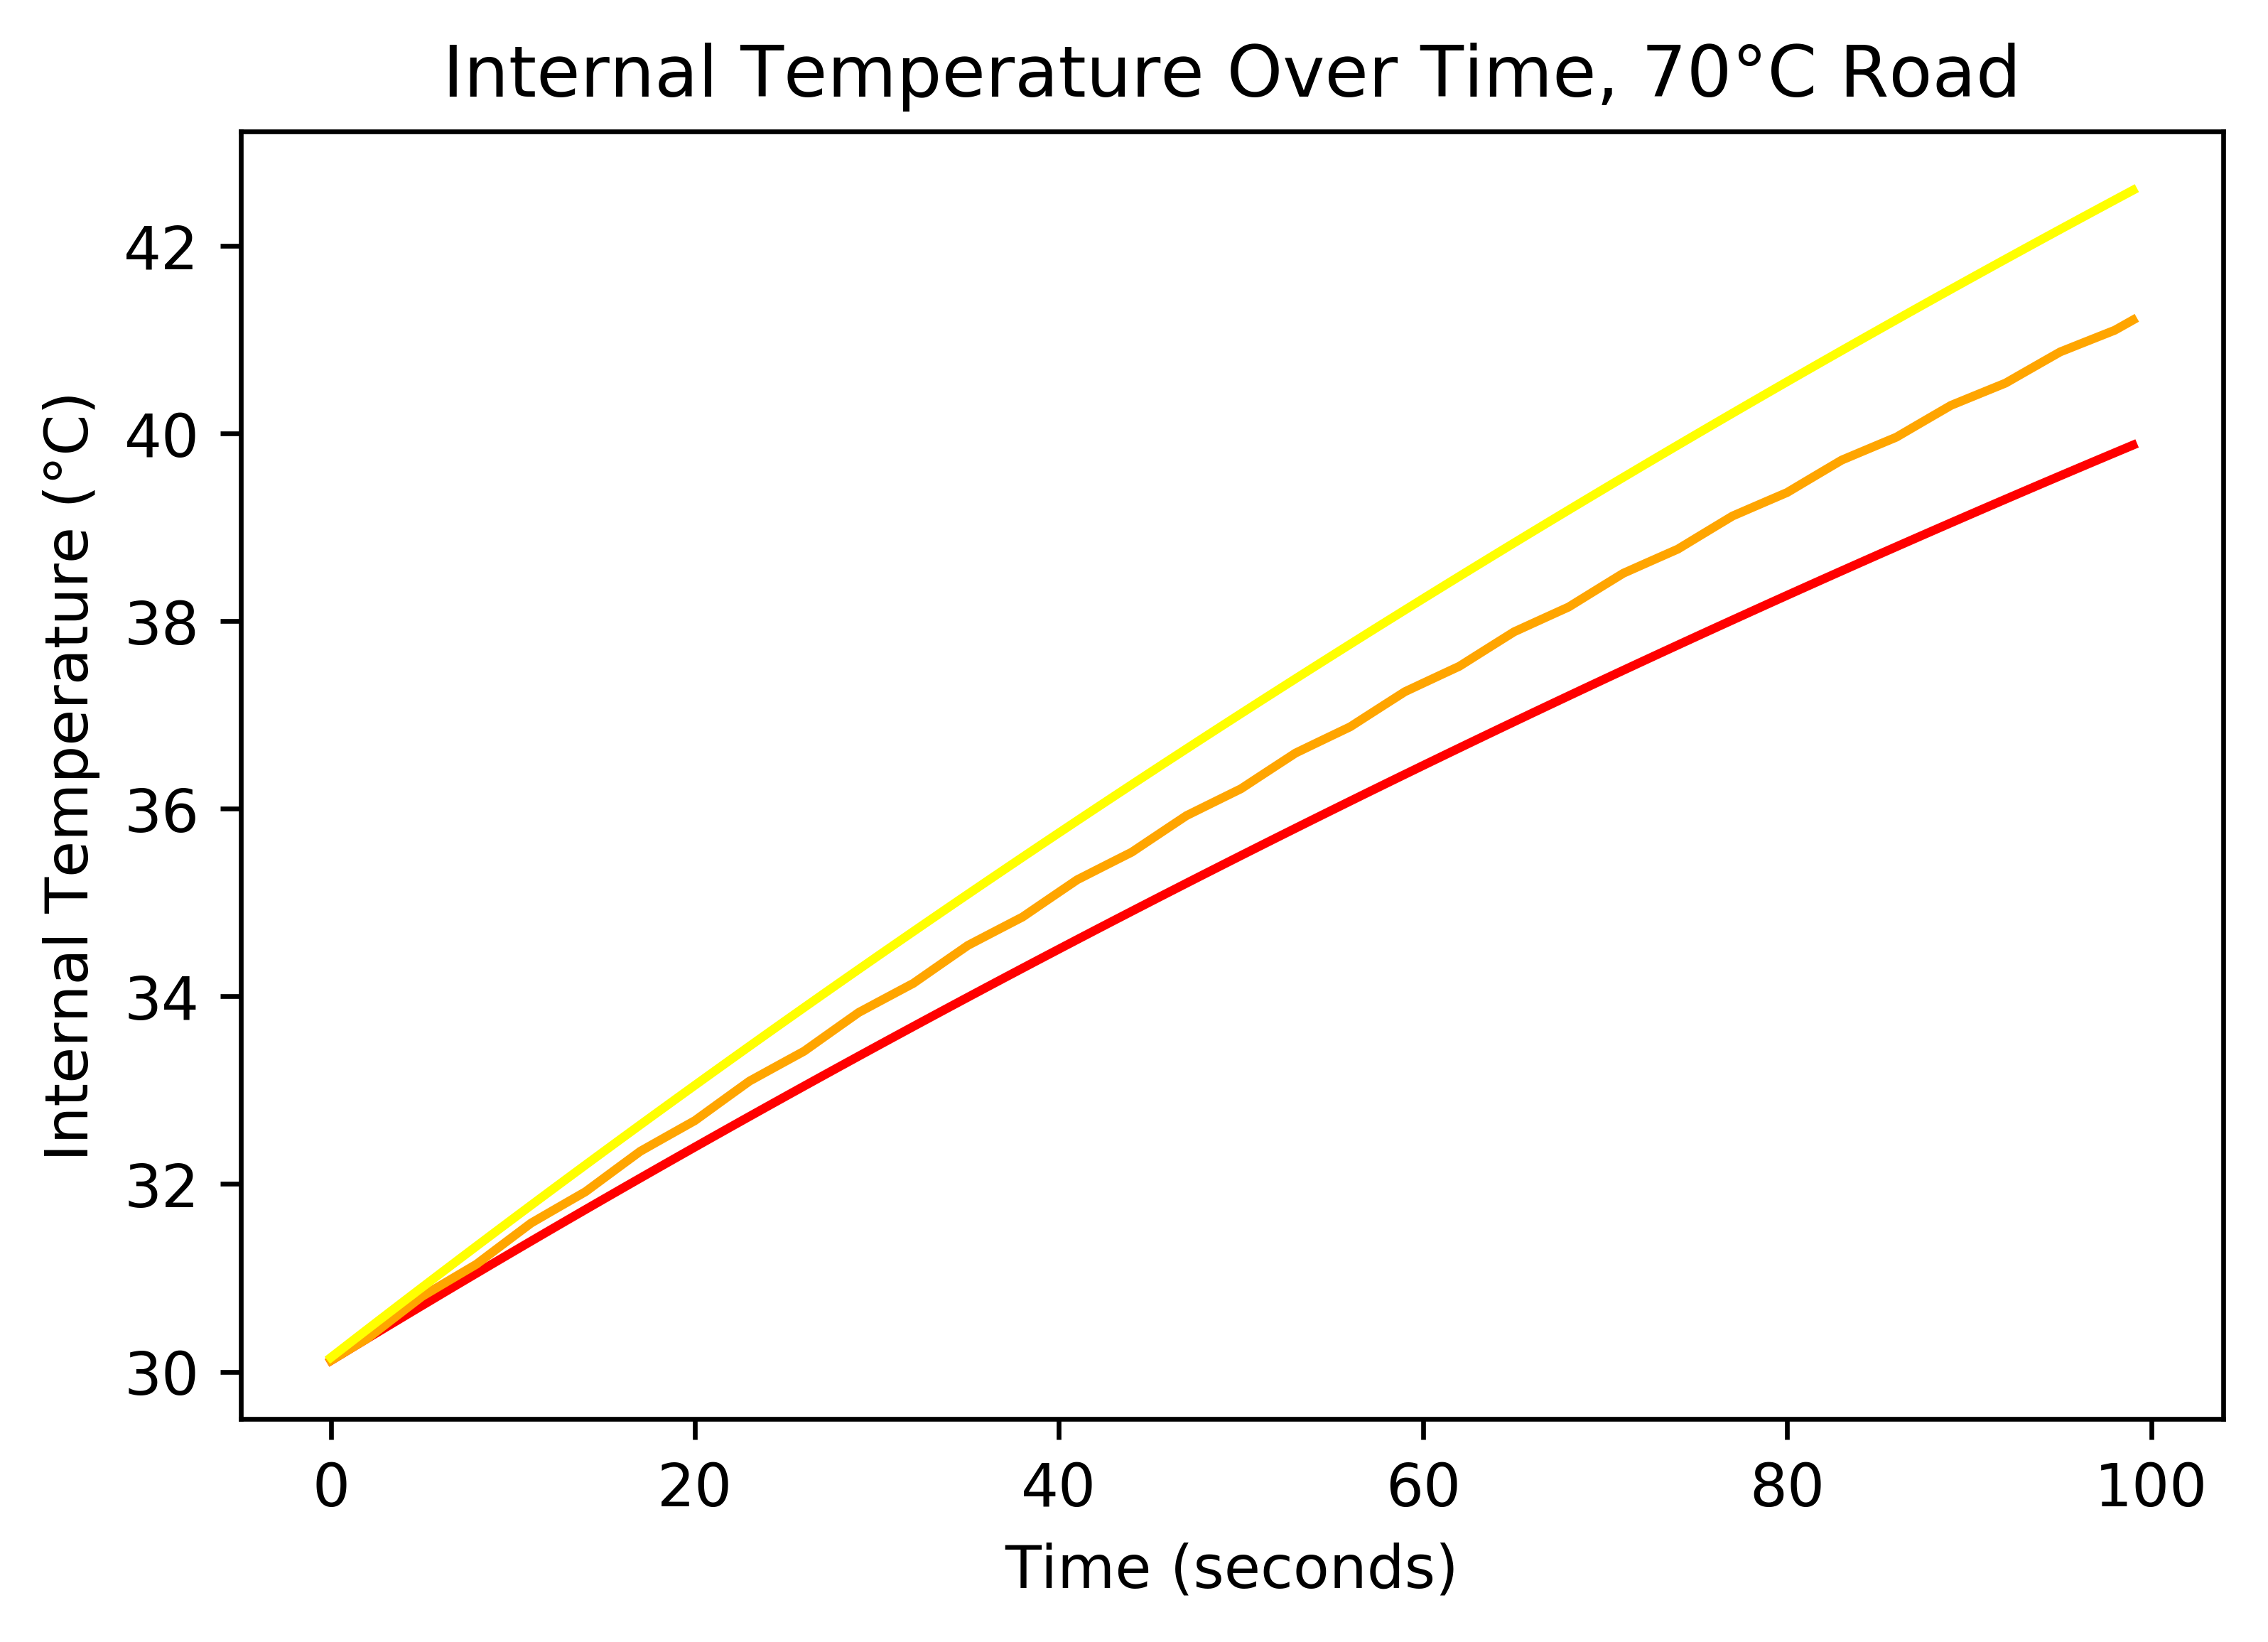

In [255]:
# USING THE PLASTRON CLASS TO CREATE GRAPHS
# THE TWO LINEPLOTS AFTER 100s AND 500s RESPECTIVELY
temps = [30, 30, 30]
p = Plastron("medium", 70, temps)
# Update for 100 seconds
for x in range(0, 100):
    p.update()
ax = p.heatmap()
ax.set_title("Plastron Temperatures After 100s, 70°C Road")
plt.savefig("./graphs/70c100sheatmap.png", dpi = 600)
plt.close()
p.scatter()
plt.title("Internal Temperature Over Time, 70°C Road")
plt.xlabel("Time (seconds)")
plt.ylabel("Internal Temperature (°C)")
plt.savefig("./graphs/70c100sscatter.png", dpi = 600)

In [254]:
# USING THE PLASTRON CLASS TO CREATE GRAPHS
# THE TWO LINEPLOTS AFTER 100s AND 500s RESPECTIVELY
temps = [30, 30, 30]
p = Plastron("medium", 70, temps)
# Update for 100 seconds
for x in range(0, 100):
    p.update()
ax = p.heatmap()
ax.set_title("Plastron Temperatures After 100s, 70°C Road")
plt.savefig("./graphs/70c100sheatmap.png", dpi = 600)
plt.close()
p.scatter()
plt.title("Internal Temperature Over Time, 70°C Road")
plt.xlabel("Time (seconds)")
plt.ylabel("Internal Temperature (°C)")
plt.savefig("./graphs/70c100sscatter.png", dpi = 600)

temps = [30, 30, 30]
p = Plastron("medium", 70, temps)
# Update for 500 seconds
for x in range(0, 500):
    p.update()
ax = p.heatmap()
ax.set_title("Plastron Temperatures After 500s, 70°C Road")
plt.savefig("./graphs/70c500sheatmap.png", dpi = 600)
plt.close()

p.scatter()
plt.plot(np.linspace(0, 100, 50), np.linspace(0, 0, 50) + 30, color="#2D3C51")
plt.plot(np.linspace(0, 100, 50), np.linspace(0, 0, 50) + 41, color="#2D3C51")
plt.plot(np.linspace(0, 0, 50), np.linspace(30, 41, 50), color="#2D3C51")
plt.plot(np.linspace(0, 0, 50) + 100, np.linspace(30, 41, 50), color="#2D3C51", label = "First 100-Second Graph")
plt.title("Internal Temperature Over Time, 70°C Road")
plt.xlabel("Time (seconds)")
plt.ylabel("Internal Temperature (°C)")
plt.legend()
plt.savefig("./graphs/70c500sscatter.png", dpi = 600)